<a href="https://colab.research.google.com/github/hanuri00/NLP/blob/main/09_02_TextClassification_Project02_seq2seq_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transformer attention

## seq2seq

In [ ]:
#10.2 Transformer attention
#10.2.1 Seq2seq

In [ ]:
from __future__ import unicode_literals, print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import pandas as pd

import os
import re
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
SOS_token = 0
EOS_token = 1
MAX_LENGTH = 20

class Lang:
    def __init__(self):
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [ ]:
def normalizeString(df, lang):
    sentence = df[lang].str.lower()
    sentence = sentence.str.replace('[^A-Za-z\s]+', '')
    sentence = sentence.str.normalize('NFD')
    sentence = sentence.str.encode('ascii', errors='ignore').str.decode('utf-8')
    return sentence

def read_sentence(df, lang1, lang2):
    sentence1 = normalizeString(df, lang1)
    sentence2 = normalizeString(df, lang2)
    return sentence1, sentence2

def read_file(loc, lang1, lang2):
    df = pd.read_csv(loc, delimiter='\t', header=None, names=[lang1, lang2])
    return df

def process_data(lang1,lang2):
    df = read_file('/content/drive/MyDrive/Colab Notebooks/eng-fra.txt', lang1, lang2) #구글 드라이브에서 파일 경로 복사 후 붙여넣으세요.
    sentence1, sentence2 = read_sentence(df, lang1, lang2)

    input_lang = Lang()
    output_lang = Lang()
    pairs = []
    for i in range(len(df)):
        if len(sentence1[i].split(' ')) < MAX_LENGTH and len(sentence2[i].split(' ')) < MAX_LENGTH:
            full = [sentence1[i], sentence2[i]]
            input_lang.addSentence(sentence1[i])
            output_lang.addSentence(sentence2[i])
            pairs.append(full)

    return input_lang, output_lang, pairs

In [ ]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensorsFromPair(input_lang, output_lang, pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, embbed_dim, num_layers):
        super(Encoder, self).__init__()
        self.input_dim = input_dim
        self.embbed_dim = embbed_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.embedding = nn.Embedding(input_dim, self.embbed_dim)
        self.gru = nn.GRU(self.embbed_dim, self.hidden_dim, num_layers=self.num_layers)

    def forward(self, src):
        embedded = self.embedding(src).view(1,1,-1)
        outputs, hidden = self.gru(embedded)
        return outputs, hidden

In [ ]:
class Decoder(nn.Module):
    def __init__(self, output_dim, hidden_dim, embbed_dim, num_layers):
        super(Decoder, self).__init__()

        self.embbed_dim = embbed_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers

        self.embedding = nn.Embedding(output_dim, self.embbed_dim)
        self.gru = nn.GRU(self.embbed_dim, self.hidden_dim, num_layers=self.num_layers)
        self.out = nn.Linear(self.hidden_dim, output_dim)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        input = input.view(1, -1)
        embedded = F.relu(self.embedding(input))
        output, hidden = self.gru(embedded, hidden)
        prediction = self.softmax(self.out(output[0]))
        return prediction, hidden

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device, MAX_LENGTH=MAX_LENGTH):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, input_lang, output_lang, teacher_forcing_ratio=0.5):

        input_length = input_lang.size(0)
        batch_size = output_lang.shape[1]
        target_length = output_lang.shape[0]
        vocab_size = self.decoder.output_dim
        outputs = torch.zeros(target_length, batch_size, vocab_size).to(self.device)

        for i in range(input_length):
            encoder_output, encoder_hidden = self.encoder(input_lang[i])

        decoder_hidden = encoder_hidden.to(device)
        decoder_input = torch.tensor([SOS_token], device=device)

        for t in range(target_length):
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
            outputs[t] = decoder_output
            teacher_force = random.random() < teacher_forcing_ratio
            topv, topi = decoder_output.topk(1)
            input = (output_lang[t] if teacher_force else topi)
            if(teacher_force == False and input.item() == EOS_token):
                break
        return outputs

In [ ]:
teacher_forcing_ratio = 0.5

def Model(model, input_tensor, target_tensor, model_optimizer, criterion):
    model_optimizer.zero_grad()
    input_length = input_tensor.size(0)
    loss = 0
    epoch_loss = 0
    output = model(input_tensor, target_tensor)
    num_iter = output.size(0)

    for ot in range(num_iter):
        loss += criterion(output[ot], target_tensor[ot])

    loss.backward()
    model_optimizer.step()
    epoch_loss = loss.item() / num_iter
    return epoch_loss

In [ ]:
def trainModel(model, input_lang, output_lang, pairs, num_iteration=20000):
    model.train()
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    criterion = nn.NLLLoss()
    total_loss_iterations = 0

    training_pairs = [tensorsFromPair(input_lang, output_lang, random.choice(pairs))
                      for i in range(num_iteration)]

    for iter in range(1, num_iteration+1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]
        loss = Model(model, input_tensor, target_tensor, optimizer, criterion)
        total_loss_iterations += loss

        if iter % 5000 == 0:
            avarage_loss= total_loss_iterations / 5000
            total_loss_iterations = 0
            print('%d %.4f' % (iter, avarage_loss))

    torch.save(model.state_dict(), f'/content/drive/MyDrive/Colab Notebooks/mytraining.pt')
    return model

In [ ]:
def evaluate(model, input_lang, output_lang, sentences, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentences[0])
        output_tensor = tensorFromSentence(output_lang, sentences[1])
        decoded_words = []
        output = model(input_tensor, output_tensor)

        for ot in range(output.size(0)):
            topv, topi = output[ot].topk(1)

            if topi[0].item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi[0].item()])
    return decoded_words

def evaluateRandomly(model, input_lang, output_lang, pairs, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('input {}'.format(pair[0]))
        print('output {}'.format(pair[1]))
        output_words = evaluate(model, input_lang, output_lang, pair)
        output_sentence = ' '.join(output_words)
        print('predicted {}'.format(output_sentence))

In [ ]:
lang1 = 'eng'
lang2 = 'fra'
input_lang, output_lang, pairs = process_data(lang1, lang2)

randomize = random.choice(pairs)
print('random sentence {}'.format(randomize))

input_size = input_lang.n_words
output_size = output_lang.n_words
print('Input : {} Output : {}'.format(input_size, output_size))

embed_size = 256
hidden_size = 512
num_layers = 1
num_iteration = 75000

encoder = Encoder(input_size, hidden_size, embed_size, num_layers)
decoder = Decoder(output_size, hidden_size, embed_size, num_layers)

model = Seq2Seq(encoder, decoder, device).to(device)

print(encoder)
print(decoder)

model = trainModel(model, input_lang, output_lang, pairs, num_iteration)

random sentence ['i dont handle ultimatums well', 'je ne gre pas bien les ultimatums']
Input : 13366 Output : 25937
Encoder(
  (embedding): Embedding(13366, 256)
  (gru): GRU(256, 512)
)
Decoder(
  (embedding): Embedding(25937, 256)
  (gru): GRU(256, 512)
  (out): Linear(in_features=512, out_features=25937, bias=True)
  (softmax): LogSoftmax(dim=1)
)
5000 4.8850
10000 4.6709
15000 4.6027
20000 4.5851
25000 4.5963
30000 4.5049
35000 4.5060
40000 4.5039
45000 4.5135
50000 4.4676
55000 4.4547
60000 4.5054
65000 4.4584
70000 4.4132
75000 4.4566


In [ ]:
evaluateRandomly(model, input_lang, output_lang, pairs)

input can i get you anything else
output puisje vous procurer quoi que ce soit dautre 
predicted je le pas le <EOS>
input she is indeed a lovely girl
output cest vraiment une fille adorable
predicted je le pas le <EOS>
input its about time you got a haircut
output il serait temps que tu te coupes les cheveux
predicted je le pas le <EOS>
input poyang lake is the largest freshwater lake in china
output le lac poyang est le plus grand lac deau douce de chine
predicted je le pas le <EOS>
input you look surprised
output vous avez lair surpris
predicted je le pas le <EOS>
input in hindsight this was a mistake
output avec le recul ctait une erreur
predicted je le pas le <EOS>
input it could be a trap
output cela pourrait tre un pige
predicted je le pas le <EOS>
input shall we walk or drive
output nous y allons  pied ou en voiture
predicted je le pas le <EOS>
input i feel like throwing up
output jai envie de dgueuler
predicted je le pas le <EOS>
input youre adorable
output vous tes adorables
p

In [ ]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

In [ ]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0
    plot_loss_total = 0

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(input_lang, output_lang, random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]
        loss = Model(model, input_tensor, target_tensor, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % 5000 == 0:
            print_loss_avg = print_loss_total / 5000
            print_loss_total = 0
            print('%d,  %.4f' % (iter, print_loss_avg))

In [ ]:
import time

embed_size = 256
hidden_size = 512
num_layers = 1
input_size = input_lang.n_words
output_size = output_lang.n_words

encoder1 = Encoder(input_size, hidden_size, embed_size, num_layers)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_size, dropout_p=0.1).to(device)

print(encoder1)
print(attn_decoder1)

attn_model = trainIters(encoder1, attn_decoder1, 75000, print_every=5000, plot_every=100, learning_rate=0.01)

Encoder(
  (embedding): Embedding(13366, 256)
  (gru): GRU(256, 512)
)
AttnDecoderRNN(
  (embedding): Embedding(25937, 512)
  (attn): Linear(in_features=1024, out_features=20, bias=True)
  (attn_combine): Linear(in_features=1024, out_features=512, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (gru): GRU(512, 512)
  (out): Linear(in_features=512, out_features=25937, bias=True)
)
5000,  4.7605
10000,  4.7334
15000,  4.7214
20000,  4.7251
25000,  4.7354
30000,  4.7388
35000,  4.7506
40000,  4.7378
45000,  4.7719
50000,  4.7333
55000,  4.7437
60000,  4.7430
65000,  4.7109
70000,  4.7223
75000,  4.7535


## BERT
(Bidirectional Encoder Representations from Transformers)

In [ ]:
#10.2.1 Bert

In [ ]:
!pip install transformers

     |████████████████████████████████| 3.4 MB 5.3 MB/s 
     |████████████████████████████████| 3.3 MB 75.3 MB/s 
     |████████████████████████████████| 596 kB 57.6 MB/s 
     |████████████████████████████████| 895 kB 71.7 MB/s 
     |████████████████████████████████| 61 kB 649 kB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
!pip install pytorch-transformers

     |████████████████████████████████| 176 kB 5.4 MB/s 
     |████████████████████████████████| 1.2 MB 50.2 MB/s 
     |████████████████████████████████| 131 kB 72.8 MB/s 
     |████████████████████████████████| 8.5 MB 49.3 MB/s 
     |████████████████████████████████| 79 kB 8.9 MB/s 
     |████████████████████████████████| 138 kB 76.9 MB/s 
     |████████████████████████████████| 127 kB 63.3 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from pytorch_transformers import BertTokenizer, BertForSequenceClassification
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/training.txt', sep='\t') #구글 드라이브에서 파일 경로 복사 후 붙여넣으세요.
valid_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/validing.txt', sep='\t') #구글 드라이브에서 파일 경로 복사 후 붙여넣으세요.
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/testing.txt', sep='\t') #구글 드라이브에서 파일 경로 복사 후 붙여넣으세요.

In [ ]:
train_df = train_df.sample(frac=0.1, random_state=500)
valid_df = valid_df.sample(frac=0.1, random_state=500)
test_df = test_df.sample(frac=0.1, random_state=500)

In [ ]:
class Datasets(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        text = self.df.iloc[idx, 1]
        label = self.df.iloc[idx, 2]
        return text, label

In [ ]:
train_dataset = Datasets(train_df)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=0)

valid_dataset = Datasets(valid_df)
valid_loader = DataLoader(valid_dataset, batch_size=2, shuffle=True, num_workers=0)

test_dataset = Datasets(test_df)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=True, num_workers=0)

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
model.to(device)

100%|██████████| 440473133/440473133 [00:07<00:00, 59240479.79B/s]


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
def save_checkpoint(save_path, model, valid_loss):
    if save_path == None:
        return
    state_dict = {'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}

    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')

def load_checkpoint(load_path, model):
    if load_path==None:
        return
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')

    model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['valid_loss']

def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):
    if save_path == None:
        return
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')

def load_metrics(load_path):
    if load_path==None:
        return
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [ ]:
def train(model,
          optimizer,
          criterion = nn.BCELoss(),
          num_epochs = 5,
          eval_every = len(train_loader) // 2,
          best_valid_loss = float("Inf")):

    total_correct = 0.0
    total_len = 0.0
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    model.train()
    for epoch in range(num_epochs):
        for text, label in train_loader:
            optimizer.zero_grad()
            encoded_list = [tokenizer.encode(t, add_special_tokens=True) for t in text]
            padded_list =  [e + [0] * (512-len(e)) for e in encoded_list]

            sample = torch.tensor(padded_list)
            sample, label = sample.to(device), label.to(device)
            labels = torch.tensor(label)
            outputs = model(sample, labels=labels)
            loss, logits = outputs

            pred = torch.argmax(F.softmax(logits), dim=1)
            correct = pred.eq(labels)
            total_correct += correct.sum().item()
            total_len += len(labels)
            running_loss += loss.item()
            loss.backward()
            optimizer.step()
            global_step += 1

            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():
                    for text, label in valid_loader:
                        encoded_list = [tokenizer.encode(t, add_special_tokens=True) for t in text]
                        padded_list =  [e + [0] * (512-len(e)) for e in encoded_list]
                        sample = torch.tensor(padded_list)
                        sample, label = sample.to(device), label.to(device)
                        labels = torch.tensor(label)
                        outputs = model(sample, labels=labels)
                        loss, logits = outputs
                        valid_running_loss += loss.item()

                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                running_loss = 0.0
                valid_running_loss = 0.0
                model.train()

                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))

                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint('/content/drive/MyDrive/Colab Notebooks/model.pt', model, best_valid_loss)
                    save_metrics('/content/drive/MyDrive/Colab Notebooks/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)

    save_metrics('/content/drive/MyDrive/Colab Notebooks/metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('훈련 종료!')

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=2e-5)
train(model=model, optimizer=optimizer)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch [1/5], Step [510/5100], Train Loss: 0.7034, Valid Loss: 0.6940
Model saved to ==> /content/drive/MyDrive/Colab Notebooks/model.pt
Model saved to ==> /content/drive/MyDrive/Colab Notebooks/metrics.pt
Epoch [1/5], Step [1020/5100], Train Loss: 0.6986, Valid Loss: 0.7357
Epoch [2/5], Step [1530/5100], Train Loss: 0.7006, Valid Loss: 0.7012
Epoch [2/5], Step [2040/5100], Train Loss: 0.7062, Valid Loss: 0.6969
Epoch [3/5], Step [2550/5100], Train Loss: 0.7103, Valid Loss: 0.7006
Epoch [3/5], Step [3060/5100], Train Loss: 0.7024, Valid Loss: 0.6927
Model saved to ==> /content/drive/MyDrive/Colab Notebooks/model.pt
Model saved to ==> /content/drive/MyDrive/Colab Notebooks/metrics.pt
Epoch [4/5], Step [3570/5100], Train Loss: 0.7079, Valid Loss: 0.6949
Epoch [4/5], Step [4080/5100], Train Loss: 0.7092, Valid Loss: 0.6974
Epoch [5/5], Step [4590/5100], Train Loss: 0.6981, Valid Loss: 0.7013
Epoch [5/5], Step [5100/5100], Train Loss: 0.7000, Valid Loss: 0.6955
Model saved to ==> /content/d

Model loaded from <== /content/drive/MyDrive/Colab Notebooks/metrics.pt


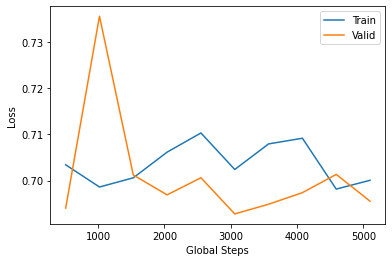

In [ ]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics('/content/drive/MyDrive/Colab Notebooks/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
def evaluate(model, test_loader):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for text, label in test_loader:
            encoded_list = [tokenizer.encode(t, add_special_tokens=True) for t in text]
            padded_list =  [e + [0] * (512-len(e)) for e in encoded_list]

            sample = torch.tensor(padded_list)
            sample, label = sample.to(device), label.to(device)
            labels = torch.tensor(label)
            output = model(sample, labels=labels)

            _, output = output
            y_pred.extend(torch.argmax(output, 1).tolist())
            y_true.extend(labels.tolist())

    print('Classification 결과:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))

    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.xaxis.set_ticklabels(['0', '1'])
    ax.yaxis.set_ticklabels(['0', '1'])

Model loaded from <== /content/drive/MyDrive/Colab Notebooks/model.pt
Classification 결과:
              precision    recall  f1-score   support

           1     0.5091    1.0000    0.6747       558
           0     0.0000    0.0000    0.0000       538

    accuracy                         0.5091      1096
   macro avg     0.2546    0.5000    0.3374      1096
weighted avg     0.2592    0.5091    0.3435      1096



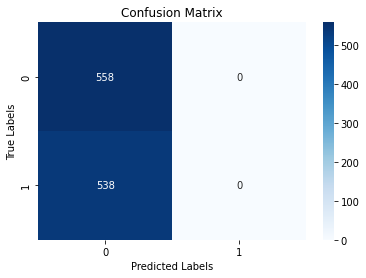

In [ ]:
import warnings
warnings.filterwarnings('ignore')
best_model = model.to(device)
load_checkpoint('/content/drive/MyDrive/Colab Notebooks/model.pt', best_model)
evaluate(best_model, test_loader)

# K-NLP

In [ ]:
# 한국어 임베딩

In [ ]:
import torch
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

Downloading:   0%|          | 0.00/972k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.87M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [ ]:
text = "나는 파이토치를 이용한 딥러닝을 학습중이다."
marked_text = "[CLS] " + text + " [SEP]"
tokenized_text = tokenizer.tokenize(marked_text)
print(tokenized_text)

['[CLS]', '나는', '파', '##이', '##토', '##치를', '이', '##용한', '딥', '##러', '##닝', '##을', '학', '##습', '##중', '##이다', '.', '[SEP]']


In [ ]:
text = "과수원에 사과가 많았다." \
       "친구가 나에게 사과했다."\
       "백설공주는 독이 든 사과를 먹었다."

marked_text = "[CLS] " + text + " [SEP]"
tokenized_text = tokenizer.tokenize(marked_text)
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

for tup in zip(tokenized_text, indexed_tokens):
    print('{:<12} {:>6,}'.format(tup[0], tup[1]))

[CLS]           101
과             8,898
##수          15,891
##원에         108,280
사             9,405
##과          11,882
##가          11,287
많             9,249
##았다         27,303
.               119
친             9,781
##구          17,196
##가          11,287
나             8,982
##에게         26,212
사             9,405
##과          11,882
##했다         12,490
.               119
백             9,331
##설          31,928
##공          28,000
##주는         100,633
독             9,088
##이          10,739
든             9,115
사             9,405
##과          11,882
##를          11,513
먹             9,266
##었다         17,706
.               119
[SEP]           102


In [ ]:
segments_ids = [1] * len(tokenized_text)
print (segments_ids)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [ ]:
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])

In [ ]:
model = BertModel.from_pretrained('bert-base-multilingual-cased',
                                  output_hidden_states = True,)

model.eval()

Downloading:   0%|          | 0.00/681M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(119547, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
         

In [ ]:
with torch.no_grad():
    outputs = model(tokens_tensor, segments_tensors)
    hidden_states = outputs[2]

In [ ]:
print ("계층 수:", len(hidden_states), "  (initial embeddings + 12 BERT layers)")
layer_i = 0

print ("배치 수:", len(hidden_states[layer_i]))
batch_i = 0

print ("토큰 수:", len(hidden_states[layer_i][batch_i]))
token_i = 0

print ("은닉층 유닛 수:", len(hidden_states[layer_i][batch_i][token_i]))

계층 수: 13   (initial embeddings + 12 BERT layers)
배치 수: 1
토큰 수: 33
은닉층 유닛 수: 768


In [ ]:
print('은닉 상태의 유형: ', type(hidden_states))
print('각 계층에서의 텐서 형태: ', hidden_states[0].size())

은닉 상태의 유형:  <class 'tuple'>
각 계층에서의 텐서 형태:  torch.Size([1, 33, 768])


In [ ]:
token_embeddings = torch.stack(hidden_states, dim=0)
token_embeddings.size()

torch.Size([13, 1, 33, 768])

In [ ]:
token_embeddings = torch.squeeze(token_embeddings, dim=1)
token_embeddings.size()

torch.Size([13, 33, 768])

In [ ]:
token_embeddings = token_embeddings.permute(1,0,2)
token_embeddings.size()

torch.Size([33, 13, 768])

In [ ]:
token_vecs_cat = []
for token in token_embeddings:
    cat_vec = torch.cat((token[-1], token[-2], token[-3], token[-4]), dim=0)
    token_vecs_cat.append(cat_vec)
print ('형태는: %d x %d' % (len(token_vecs_cat), len(token_vecs_cat[0])))

형태는: 33 x 3072


In [ ]:
token_vecs_sum = []
for token in token_embeddings:
    sum_vec = torch.sum(token[-4:], dim=0)
    token_vecs_sum.append(sum_vec)
print ('형태는: %d x %d' % (len(token_vecs_sum), len(token_vecs_sum[0])))

형태는: 33 x 768


In [ ]:
token_vecs = hidden_states[-2][0]
sentence_embedding = torch.mean(token_vecs, dim=0)
print ("최종 임베딩 벡터의 형태:", sentence_embedding.size())

최종 임베딩 벡터의 형태: torch.Size([768])


In [ ]:
for i, token_str in enumerate(tokenized_text):
    print (i, token_str)

0 [CLS]
1 과
2 ##수
3 ##원에
4 사
5 ##과
6 ##가
7 많
8 ##았다
9 .
10 친
11 ##구
12 ##가
13 나
14 ##에게
15 사
16 ##과
17 ##했다
18 .
19 백
20 ##설
21 ##공
22 ##주는
23 독
24 ##이
25 든
26 사
27 ##과
28 ##를
29 먹
30 ##었다
31 .
32 [SEP]


In [ ]:
print("사과가 많았다", str(token_vecs_sum[6][:5]))
print("나에게 사과했다", str(token_vecs_sum[10][:5]))
print("사과를 먹었다", str(token_vecs_sum[19][:5]))

사과가 많았다 tensor([-0.5844, -4.0836,  0.4906,  0.8915, -1.8054])
나에게 사과했다 tensor([-0.8631, -3.4047, -0.7351,  0.9805, -2.6700])
사과를 먹었다 tensor([ 0.6756, -0.3618,  0.0586,  2.2050, -2.4193])


In [ ]:
from scipy.spatial.distance import cosine
diff_apple = 1 - cosine(token_vecs_sum[5], token_vecs_sum[27])
same_apple = 1 - cosine(token_vecs_sum[5], token_vecs_sum[16])
print('*유사한* 의미에 대한 벡터 유사성:  %.2f' % same_apple)
print('*다른* 의미에 대한 벡터 유사성:  %.2f' % diff_apple)

*유사한* 의미에 대한 벡터 유사성:  0.86
*다른* 의미에 대한 벡터 유사성:  0.91
